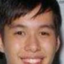

In [1]:
from torchvision import transforms

re_size = 64
crop_size = 108
offset_height = (218 - crop_size) // 2
offset_width = (178 - crop_size) // 2
crop = lambda x: x[:, offset_height:offset_height + crop_size, offset_width:offset_width + crop_size]    

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(crop),
    transforms.ToPILImage(),
    transforms.Resize((re_size, re_size)),
])


cls = 5
id = '093951'

path = f'data/private/{cls-1}/{id}.jpg'

from PIL import Image

img = Image.open(path)

img = train_transform(img)
img.show()

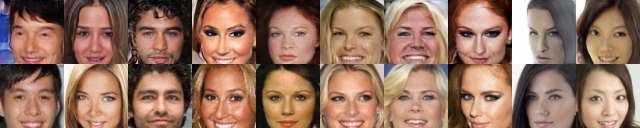

In [ ]:
import os
from PIL import Image

path = 'leakpro_output/matched_img/'

# You can skip transformations if you want original images
# If you have a train_transform function, you can add it back

def load_images(path):
    real_images = {}
    fake_images = {}
    
    for filename in os.listdir(path):
        if filename.endswith('.png'):
            label = None
            if '_real' in filename:
                label = filename.split('_')[0]
                real_images[label] = Image.open(os.path.join(path, filename))
            elif '_image_' in filename:
                parts = filename.split('_')
                label = parts[1]
                if label not in fake_images:
                    fake_images[label] = Image.open(os.path.join(path, filename))
    
    return real_images, fake_images

# Now merge

def merge_images(real_images, fake_images):
    labels = sorted(set(real_images.keys()) & set(fake_images.keys()), key=lambda x: int(x))
    
    pairs = []
    for label in labels:
        fake = fake_images[label]
        real = real_images[label]

        # Ensure both are the same width (resize if necessary)
        if fake.size != real.size:
            real = real.resize(fake.size)

        # Stack vertically (fake on top, real below)
        stacked = Image.new('RGB', (fake.width, fake.height * 2))
        stacked.paste(fake, (0, 0))
        stacked.paste(real, (0, fake.height))
        pairs.append(stacked)
    
    # Now stitch all pairs horizontally
    total_width = sum(img.width for img in pairs)
    max_height = max(img.height for img in pairs)
    combined = Image.new('RGB', (total_width, max_height))
    
    x_offset = 0
    for img in pairs:
        combined.paste(img, (x_offset, 0))
        x_offset += img.width

    return combined

# Running the functions
real_images, fake_images = load_images(path)
final_image = merge_images(real_images, fake_images)

# Save or show
#final_image.save('merged_output.png')
final_image.show()



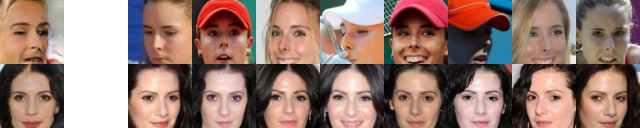

In [5]:
import os
from PIL import Image
import torch
from torchvision import transforms

# Paths and IDs
fake_1_path = 'leakpro_output/results/img_good/label_335_image_32.png'
fake_2_path = 'leakpro_output/results/img_good/label_197_image_4.png'

real_ids_1 = ['001246', '001916', '012220', '017751', '035734', '128064', '129778', '108885']
real_ids_2 = ['017484', '023727', '035029', '159380', '138835', '123359', '045374', '141499']

real_base_path = 'data/private/'

# Transform
re_size = 64
crop_size = 108
offset_height = (218 - crop_size) // 2
offset_width = (178 - crop_size) // 2
crop = lambda x: x[:, offset_height:offset_height + crop_size, offset_width:offset_width + crop_size]

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(crop),
    transforms.ToPILImage(),
    transforms.Resize((re_size, re_size)),
])

# Helper to load and transform an image
def load_image(path):
    img = Image.open(path)
    img = train_transform(img)
    return img

# Create one row (fake + padding + reals)
def create_row(fake_path, real_ids, class_id, padding=64):
    fake_img = Image.open(fake_path)
    real_imgs = [load_image(os.path.join(real_base_path, str(class_id), f'{rid}.jpg')) for rid in real_ids]
    
    # Padding image
    pad_img = Image.new('RGB', (padding, fake_img.height), color=(255, 255, 255))

    # Concatenate: fake | padding | reals
    images = [fake_img, pad_img] + real_imgs
    total_width = sum(img.width for img in images)
    max_height = max(img.height for img in images)

    row = Image.new('RGB', (total_width, max_height), color=(255, 255, 255))
    x_offset = 0
    for img in images:
        row.paste(img, (x_offset, 0))
        x_offset += img.width

    return row

# Create both rows
row1 = create_row(fake_1_path, real_ids_1, 335)
row2 = create_row(fake_2_path, real_ids_2, 197)

# Stack the two rows vertically
final_height = row1.height + row2.height
final_width = max(row1.width, row2.width)

final_img = Image.new('RGB', (final_width, final_height), color=(255, 255, 255))
final_img.paste(row1, (0, 0))
final_img.paste(row2, (0, row1.height))

# Save or show
final_img.save('real_fake_rows.png')
final_img.show()


